# COSMOS Soil Moisture Network
http://cosmos.hwr.arizona.edu/

In [1]:
# %pylab widget
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')
import ipywidgets

In [3]:
import podpac
from podpac.datalib import cosmos_stations

# Accessing COSMOS data

In [4]:
# Create encapsulated COSMOS data source
cosmos = cosmos_stations.COSMOSStations(
    cache_ctrl=['ram', 'disk']  # I want to save my queries to disk for offline availability
)

In [5]:
# cosmos.rem_cache("*")  # If needed, clear cache for this Node to get freshly downloaded data

In [5]:
# Select lat/lon bounds for queries (TODO: Make UI)
bounds = {"lat": [40, 46], "lon": [-78, -68]}
# Source coordinates gives the lat/lon coordinates for each COSMOS station in the network
lat_lon_coords = cosmos.source_coordinates.select(bounds)  # Filter stations by given bounds
lat_lon_coords

Coordinates (EPSG:4326)
	lat_lon[lat]: ArrayCoordinates1d(lat): Bounds[40.6646, 45.2041], N[5]
	lat_lon[lon]: ArrayCoordinates1d(lon): Bounds[-77.9067, -68.7359], N[5]

In [6]:
# Select the time range (TODO: Make a UI)
time_coords = podpac.Coordinates([
    podpac.crange("2018-05-01",  # start time
                  "2018-06-01",  # end time
                  "1,D",         # step size (1 day) 
                  "time")        # Name of dimension
])
time_coords

Coordinates (EPSG:4326)
	time: UniformCoordinates1d(time): Bounds[2018-05-01, 2018-06-01], N[32]

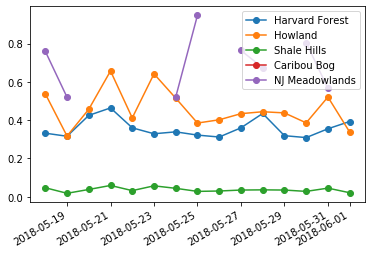

In [7]:
# Get and plot the data
coords = podpac.coordinates.merge_dims([time_coords, lat_lon_coords])
out = cosmos.eval(coords)
close(1); fig = figure(1)
plot(out.time, out.data, 'o-')
fig.autofmt_xdate()
legend(cosmos.label_from_latlon(coords))

# Examining a COSMOS site more closely
Caribou Bog data is missing, let's examine some of the details of this station

In [8]:
caribou_data = cosmos.get_station_data('Caribou')  # queries can match partial string names
caribou_data

[{'label': 'Caribou Bog',
  'type': 'He3',
  'sitenumber': '066',
  'location': (44.9167, -68.7359),
  'elevation': 39.0,
  'pressure': 1005,
  'rigidity': 1.59,
  'N0cal': 2500.0,
  'network': 'COSMOS-A',
  'lastdat': numpy.datetime64('2013-06-17'),
  'lastsm': 75.0,
  'yestdat': 0.0,
  'yestfla': 0.0,
  'weekdat': 0.0,
  'weekfla': 0.0,
  'smreg': '> 35%',
  'iridium': 300234010373870.0,
  'hydroinnova': 'HI-1000-1048',
  'atag': 'A323352',
  'caltype': 'U',
  'year': numpy.datetime64('2012-06-05')}]

Looks like the Caribou Bog station was installed in 2012, it may not be operational in 2018. Let's try a different date.

In [9]:
# Select the time range (TODO: Make a UI)
time_coords2 = podpac.Coordinates([
    podpac.crange("2013-05-01",  # Start closer to installation date for sensor
                  "2013-06-01",  # End date
                  "3,h",         # Do a 3-hour timestep instead
                  "time")
])

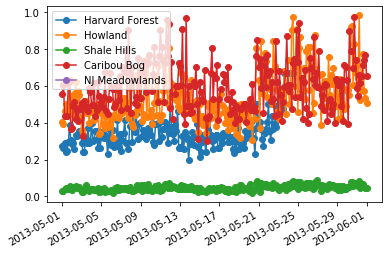

In [10]:
# Get and plot the data
coords = podpac.coordinates.merge_dims([time_coords2, lat_lon_coords])
out = cosmos.eval(coords)
close(2);fig = figure(2)
plot(out.time, out.data, 'o-')
legend(cosmos.label_from_latlon(coords))
fig.autofmt_xdate()

# Site properties and calibration data
We can also look at the calibration data and properties for a site

In [11]:
properties = cosmos.get_site_properties('Bog')  # Now matching the 'Bog' part of 'Caribou Bog'
properties

[{'Installation Date:': numpy.datetime64('2012-06-05'),
  'Location (lat,lon):': (44.9167, -68.7359),
  'Elevation (m asl):': 39.0,
  'Timezone (UTC):': -5.0,
  'Cutoff Rigidity (GV):': 1.59,
  'Mean Pressure (mb):': 1005.0,
  'Lattice Water (%):': 4.3,
  'Soil Organic Carbon (%):': 0.02,
  'Max Count Rate (/hr):': 2500.0}]

In [12]:
cal_data = cosmos.get_calibration_data('SMAP')
cal_data[0]['items'][:2]

[{'date': numpy.datetime64('2010-07-23'),
  'label': 1,
  'Tin_Label': 86.0,
  'Location': 'NEE25',
  'Depth_cm': '0.5-5.5 cm',
  'Volumetric': '---',
  'Wet_total_g': 38.82,
  'Dry_total_g': 37.89,
  'Tare_g': 29.72,
  'Wet_soil_g': 9.1,
  'Dry_soil_g': 8.17,
  'Soil_water_w_%': 11.38,
  'Bulk_density': None,
  'Soil_water_v_%': 15.76},
 {'date': numpy.datetime64('2010-07-23'),
  'label': 2,
  'Tin_Label': 125.0,
  'Location': 'NEE25',
  'Depth_cm': '5-10 cm',
  'Volumetric': '---',
  'Wet_total_g': 56.31,
  'Dry_total_g': 53.53,
  'Tare_g': 29.39,
  'Wet_soil_g': 26.92,
  'Dry_soil_g': 24.14,
  'Soil_water_w_%': 11.52,
  'Bulk_density': None,
  'Soil_water_v_%': 15.94}]

# Examine overall network properties
We can look at some summary data for the COSMOS network as well

In [13]:
cosmos.available_data_keys

['label',
 'type',
 'sitenumber',
 'location',
 'elevation',
 'pressure',
 'rigidity',
 'N0cal',
 'network',
 'lastdat',
 'lastsm',
 'yestdat',
 'yestfla',
 'weekdat',
 'weekfla',
 'smreg',
 'iridium',
 'hydroinnova',
 'atag',
 'caltype',
 'year']

Text(0, 0.5, 'Pressure')

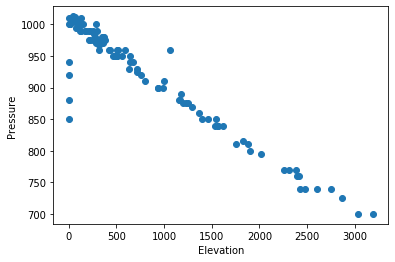

In [14]:
elevation = cosmos.stations_value('elevation')
pressure = cosmos.stations_value('pressure')
close(3); figure(3)
plot(elevation, pressure, 'o')
xlabel("Elevation")
ylabel("Pressure")

# Computing mean quantities
The hourly soil moisture seems the vary significantly. Let's find daily averages for COSMOS data intead.

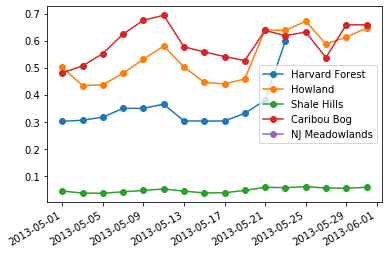

In [15]:
daily_cosmos = podpac.algorithm.ResampleReduce(
    source=cosmos,
    resample='2D',
    reduce_fn='mean')
out = daily_cosmos.eval(coords)
close(4);fig = figure(4)
plot(out.time, out.data, 'o-')
fig.autofmt_xdate()
legend(cosmos.label_from_latlon(coords))